Finally, we get to the Navier-Stokes equations, with this series of equations. The first 2 are for velocity, in either direction, with the final one being a pressure expression:

$$ \frac{\delta u}{\delta t} + u\frac{\delta u}{\delta x} + v \frac{\delta u}{\delta y} = -\frac{1}{p} \frac{\delta p}{\delta x} + \eta (\frac{\delta ^2 u}{\delta x^2} + \frac{\delta ^2 u}{\delta y ^2}) $$

$$ \frac{\delta v}{\delta t} + u\frac{\delta v}{\delta x} + v \frac{\delta v}{\delta y} = -\frac{1}{p} \frac{\delta p}{\delta y} + \eta (\frac{\delta ^2 v}{\delta x^2} + \frac{\delta ^2 v}{\delta y ^2}) $$

$$\frac{\delta ^2 p}{\delta x^2} + \frac{\delta ^2 p}{\delta y^2} = -\rho (\frac{\delta u}{\delta x}\frac{\delta u}{\delta x} + 2 \frac{\delta u}{\delta y}\frac{\delta v}{\delta x} + \frac{\delta v}{\delta y}\frac{\delta v}{\delta y})$$

These can be discretised and solved for the appropriate terms ($u_{i,j}^{n+1}$, $v_{i,j}^{n+1}$, and $p_{i,j}^n$).

$$ u_{i,j}^{n+1} = u_{i,j}^n - u_{i,j}^n \frac{\Delta t}{\Delta x} (u_{i,j}^n - u_{i-1,j}^n) - v_{i,j}^n \frac{\Delta t}{\Delta y} (u_{i,j}^n - u_{i,j-1}^n) - \frac{\Delta t}{2p\Delta x} (p_{i+1,j}^n - p_{i-1,j}^n) + \eta (\frac{\Delta t}{\Delta x^2}(u_{i+1,j}^n - 2u_{i,j}^n + u_{i-1,j}^n) + \frac{\Delta t}{\Delta y^2} (u_{i,j+1} - 2u_{i,j}^n + u_{i,j-1}))$$


$$ v_{i,j}^{n+1} = v_{i,j}^n - u_{i,j}^n \frac{\Delta t}{\Delta x} (v_{i,j}^n - v_{i-1,j}^n) - v_{i,j}^n \frac{\Delta t}{\Delta y} (v_{i,j}^n - v_{i,j-1}^n) - \frac{\Delta t}{2p\Delta y} (p_{i,j+1}^n - p_{i,j-1}^n) + \eta (\frac{\Delta t}{\Delta x^2}(v_{i+1,j}^n - 2v_{i,j}^n + v_{i-1,j}^n) + \frac{\Delta t}{\Delta y^2} (v_{i,j+1} - 2v_{i,j}^n + v_{i,j-1}))$$


$$ p_{i,j}^n = \frac{(p_{i+1,j}^n + p_{i-1,j}^n) \Delta y^2 + (p_{i,j+1}^n + p_{i,j-1}^n) \Delta x^2}{2(\Delta x^2 + \Delta y^2)} - \frac{\rho \Delta x^2 \Delta y^2}{2(\Delta x^2 + \Delta y^2)} \times b$$

Where b:

$$b = \frac{1}{\Delta t} (\frac{u_{i+1,j}^n - u_{i-1,j}^n}{2\Delta x} + \frac{v_{i,j+1}^n - v_{i,j-1}}{2\Delta y}) - \frac{u_{i+1,j}^n - u_{i-1,j}^n}{2\Delta x} \frac{u_{i+1,j}^n - u_{i-1,j}^n}{2\Delta x} - 2 \frac{u_{i,j+1}^n - u_{i,j-1}^n}{2\Delta y} \frac{v_{i+1,j}^n - v_{i-1,j}^n}{2\Delta x} - \frac{v_{i,j+1}^n - u_{i,j-1}^n}{2\Delta y} \frac{v_{i,j+1}^n - u_{i,j-1}^n}{2\Delta y}$$


These equations are very long, so I'm hoping that these are fully correct.

The initial conditions are as follows:
u,v, and p = 0 everywhere


The boundary conditions are as follows:

u=1 at y=2 ("the lid")

u, and v = 0 at other boundaries

$\frac{\delta p}{\delta y} = 0$ at y = 0

p = 0 at y = 2

$\frac{\delta p}{\delta x} = 0$ at x = 0,2

In [1]:
#Importing packages

#Plotting library that is new to me
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
#Defined initial conditions

nx = 41
ny = 41
steps = 500
steps_poisson = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)


#Creating grid
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

#Parameters
rho = 1
vis = .1
dt = .001

def init(ny, nx):

    #Variable storage grids
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx)) 
    b = np.zeros((ny, nx))


    #Boundary conditions
    u[0, :]  = 0
    u[:, 0]  = 0
    u[:, -1] = 0
    u[-1, :] = 1
    v[0, :]  = 0
    v[-1, :] = 0
    v[:, 0]  = 0
    v[:, -1] = 0
    
    return u, v, p, b

In [3]:
#Function to calculate the b term
#Copied directly from article to avoid typing mistakes

def build_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    
    return b

In [4]:
#Pressure equation
def pressure_poisson(p, dx, dy, b, steps_poisson):
    for i in range(steps_poisson):
    
        pnext = p.copy()
    
        pnext[1:-1, 1:-1] = (((p[1:-1, 2:] + p[1:-1, 0:-2]) * dy**2 + 
                            (p[2:, 1:-1] + p[0:-2, 1:-1]) * dx**2) /
                            (2 * (dx**2 + dy**2)) -
                            dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                            b[1:-1,1:-1])

        pnext[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        pnext[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        pnext[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        pnext[-1, :] = 0        # p = 0 at y = 2
        
        p, pnext = pnext, p
    
    return p

In [5]:
#Full update method utilising all expressions
def cavity_flow(steps, steps_poisson, nx, ny, dt, dx, dy, rho, vis):
    u, v, b, p = init(ny, nx)
    
    unext = u.copy()
    vnext = v.copy()
    
    for i in range(steps):
        b = build_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b, steps_poisson)
        
        unext[1:-1, 1:-1] = (u[1:-1, 1:-1]-
                         u[1:-1, 1:-1] * dt / dx *
                        (u[1:-1, 1:-1] - u[1:-1, 0:-2]) -
                         v[1:-1, 1:-1] * dt / dy *
                        (u[1:-1, 1:-1] - u[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         vis * (dt / dx**2 *
                        (u[1:-1, 2:] - 2 * u[1:-1, 1:-1] + u[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (u[2:, 1:-1] - 2 * u[1:-1, 1:-1] + u[0:-2, 1:-1])))

        vnext[1:-1,1:-1] = (v[1:-1, 1:-1] -
                        u[1:-1, 1:-1] * dt / dx *
                       (v[1:-1, 1:-1] - v[1:-1, 0:-2]) -
                        v[1:-1, 1:-1] * dt / dy *
                       (v[1:-1, 1:-1] - v[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        vis * (dt / dx**2 *
                       (v[1:-1, 2:] - 2 * v[1:-1, 1:-1] + v[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (v[2:, 1:-1] - 2 * v[1:-1, 1:-1] + v[0:-2, 1:-1])))
        
        #Boundary conditions
        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
    
    
        unext, u = u, unext
        vnext, v = v, vnext
        
    return u, v, p

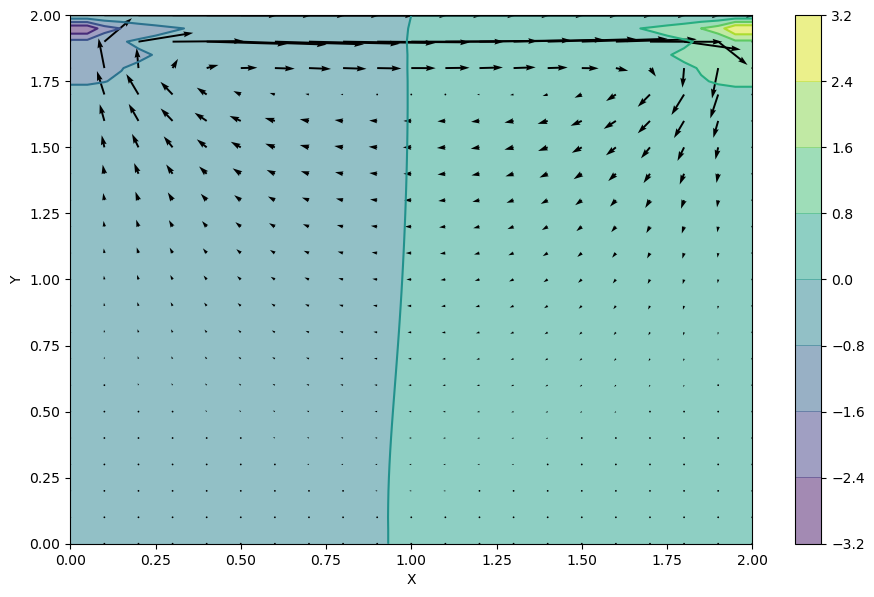

In [7]:
#Run function for 100 steps
steps = 100

u, v, p = cavity_flow(steps, steps_poisson, nx, ny, dt, dx, dy, rho, vis)

def plot(X, Y, u, v, p):
    #Contour plot
    fig = plt.figure(figsize=(11,7), dpi=100)
    # plotting the pressure field as a contour
    plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
    plt.colorbar()
    # plotting the pressure field outlines
    plt.contour(X, Y, p, cmap=cm.viridis)  
    # plotting velocity field
    plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
    plt.xlabel('X')
    plt.ylabel('Y');
    
plot(X, Y, u, v, p)

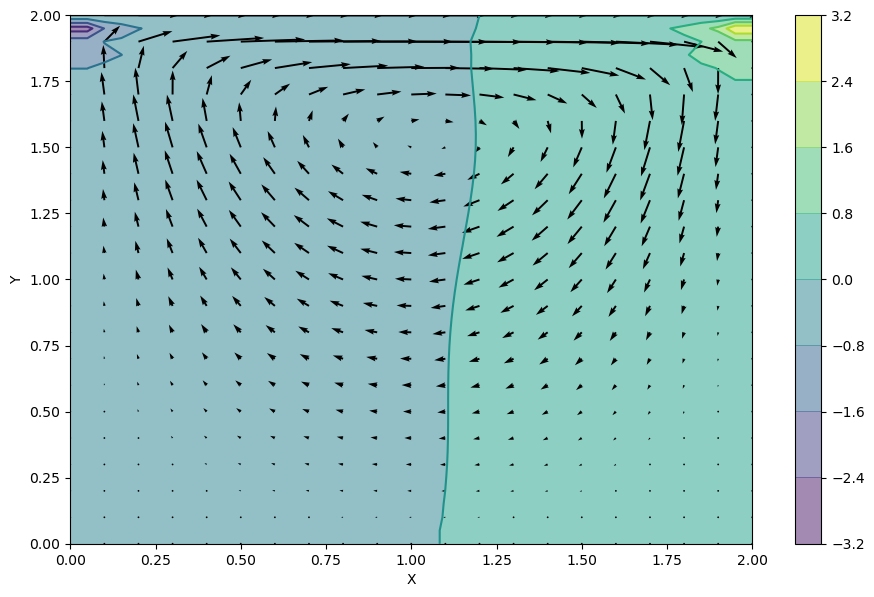

In [8]:
#Run function for 1000 steps
steps = 1000

u, v, p = cavity_flow(steps, steps_poisson, nx, ny, dt, dx, dy, rho, vis)

plot(X,Y,u,v,p)